In [1]:
import os
from collections import defaultdict
from itertools import chain
from pprint import pprint

import pandas as pd

with open(os.path.join("..", "data/tesstrain/kbd/configs/kbd.wordlist"), "r", encoding="utf-8") as f:
    words_from_dict = set(f.read().split("\n"))


def get_words_from_diff(pdf_dir, filter_prefix=None):
    interesting_words = set()

    cmpr_dirs = [d for d in os.listdir(pdf_dir) if d.startswith("cmpr_")]
    if filter_prefix:
        cmpr_dirs = [d for d in cmpr_dirs if d.startswith(filter_prefix)]

    diff_counts = defaultdict(int)
    for cmpr_dir in cmpr_dirs:
        df = pd.read_csv(os.path.join(pdf_dir, cmpr_dir, "diff_words.csv"))

        for col in df.columns:
            col_values = set(df[col].dropna().values)
            diff_counts[cmpr_dir] = len(col_values)
            uniq_words = set(chain.from_iterable([col_value.split(" ") for col_value in col_values]))
            interesting_words.update(uniq_words)

    pprint(sorted(diff_counts.items(), key=lambda x: x[1], reverse=True))
    return diff_counts, interesting_words

In [2]:
import csv
from tokenizers import Tokenizer
import nltk
from tqdm import tqdm


tokenizer_uni = Tokenizer.from_file(os.path.join("../dags/src/spellcheck/data/", "tokenizer_unigram_50k.json"))

tokenizer_bpe = Tokenizer.from_file(os.path.join("../dags/src/spellcheck/data/", "tokenizer_bpe_30000.json"))


def analyze_words(words_from_text, words_from_dictionary, output_dir):
    words_from_text = set(words_from_text)
    words_from_dictionary = set(words_from_dictionary)

    exist_words = words_from_text.intersection(words_from_dictionary)
    not_exist_words = words_from_text.difference(words_from_dictionary)
    error_percentage = len(not_exist_words) / len(words_from_text) * 100

    with open(os.path.join(output_dir, "words_rslt_exist_dictionary.txt"), "w") as f:
        f.write("\n".join(exist_words))

    with open(os.path.join(output_dir, "words_rslt_not_exist_dictionary.txt"), "w") as f:
        f.write("\n".join(not_exist_words))

    df = pd.DataFrame(
        {
            "not_exist_words": list(not_exist_words),
        }
    )

    df["tokenized_uni"] = df["not_exist_words"].apply(lambda x: "|".join(tokenizer_uni.encode(x).tokens))
    df["tokenized_bpe"] = df["not_exist_words"].apply(lambda x: "|".join(tokenizer_bpe.encode(x).tokens))

    df.to_csv(
        os.path.join(output_dir, "words_rslt_not_exist_dictionary.csv"), index=False, sep=",", quoting=csv.QUOTE_ALL
    )
    return exist_words, not_exist_words, error_percentage


def get_words_from_txt(pdf_dir, filter_prefix=None):
    rslt_dirs = [d for d in os.listdir(pdf_dir) if d.startswith("rslt_")]
    print(os.listdir(pdf_dir), rslt_dirs)
    if filter_prefix:
        rslt_dirs = [d for d in rslt_dirs if d.startswith(filter_prefix)]

    rslt_exist_dictionary = defaultdict(int)
    rslt_not_exist_dictionary = defaultdict(int)
    rslt_error_percentage = defaultdict(int)
    for rslt_dir in tqdm(rslt_dirs):
        txt_dir = os.path.join(pdf_dir, rslt_dir, "txts")
        txt_files = [f for f in os.listdir(txt_dir) if f.endswith(".txt")]

        result_words = set()
        for txt_file in txt_files:
            with open(os.path.join(txt_dir, txt_file), "r") as f:
                txt = f.read()
                words = set(nltk.word_tokenize(txt))
                result_words.update(words)

        if len(result_words) == 0:
            continue

        exist_words, not_exist_words, error_percentage = analyze_words(
            words_from_text=result_words,
            words_from_dictionary=words_from_dict,
            output_dir=os.path.join(pdf_dir, rslt_dir),
        )

        rslt_exist_dictionary[rslt_dir] = len(exist_words)
        rslt_not_exist_dictionary[rslt_dir] = len(not_exist_words)
        rslt_error_percentage[rslt_dir] = error_percentage

    return rslt_exist_dictionary, rslt_not_exist_dictionary, rslt_error_percentage

In [3]:
pdf_dir = os.path.join("..", "data/dag_results/pdf_processing/dysche_zhyg.pdf")
pdf_name = os.path.basename(pdf_dir).split(".")[0]


exist_dictionary, not_exist_dictionary, percentage = get_words_from_txt(pdf_dir, filter_prefix=None)

['cmpr_kbd_0.009_4360_66700_vs_collected_2_from_oshamaho_new_font_0.216_4374_18500', 'cmpr_kbd_0.009_4360_66700_vs_collected_2_from_oshamaho_0.011_3487_49800', 'cmpr_kbd_0.009_4360_66700_vs_low_confidence_lines_dysche_zhyg_0.010_1539_19100', 'rslt_kbd_ng_0.097_1738_38300', 'cmpr_kbd_0.009_4360_66700_vs_kbd_font_georgia_0.052_1946_16900', 'cmpr_kbd_0.009_4360_66700_vs_kbd_ng_0.097_1738_38300', 'cmpr_kbd_0.009_4360_66700_vs_kbd_ng_5_0.009_2337_15500', 'rslt_freq_100k_oshamaho_0.009_1288_8000', 'cmpr_kbd_0.009_4360_66700_vs_collected_4_from_oshamaho_0.011_3406_40000', 'cmpr_kbd_0.009_4360_66700_vs_bigrams_freq_1_5000_adyghepsale_ru_0.009_127_8000', 'cmpr_kbd_0.009_4360_66700_vs_ng_lines_1000_11_oshamaho_0.000_0_100', 'cmpr_kbd_0.009_4360_66700_vs_bigrams_freq_1_5000_hight_adyghepsale_ru_0.005_313_12400', 'rslt_ng_lines_2_0.087_3001_20000', 'rslt_bg_5k_adyghepsale_oshamaho_0.004_18_3100', 'cmpr_kbd_0.009_4360_66700_vs_bigrams_freq_5000_adyghepsale_ru_0.010_1155_8200', 'cmpr_kbd_0.009_4360_

100%|██████████| 23/23 [00:04<00:00,  5.17it/s]


In [4]:
pprint(sorted(exist_dictionary.items(), key=lambda x: x[1]))
pprint(sorted(not_exist_dictionary.items(), key=lambda x: x[1], reverse=True))
pprint(sorted(percentage.items(), key=lambda x: x[1], reverse=True))

[('rslt_freq_100k_oshamaho_0.009_1288_8000', 9088),
 ('rslt_ng_lines_0.025_1895_18400', 9127),
 ('rslt_ng_lines_2_0.087_3001_20000', 9242),
 ('rslt_40k_char_ngrams_0_40k_bg_5k_oshamaho_0.004_19_2500', 9407),
 ('rslt_kbd_ng_2_0.014_2515_16600', 9515),
 ('rslt_bg_5k_adyghepsale_oshamaho_0.004_18_3100', 9566),
 ('rslt_bg_5k_oshamaho_new_font_0.008_1750_15300', 9580),
 ('rslt_best_plus_bg_5k_oshamaho_plus_interest_0.033_219_6900', 9581),
 ('rslt_kbd_ng_2_plus_bg_5k_oshamaho_0.005_19_2700', 9598),
 ('rslt_kbd_ng_5_0.009_2337_15500', 9625),
 ('rslt_kbd_ng_1_0.007_2348_18300', 9634),
 ('rslt_best_plus_bg_5k_oshamaho_0.004_56_3600', 9701),
 ('rslt_kbd_0.009_4360_66700', 9768),
 ('rslt_kbd_ng_0.185_228_3700', 9796),
 ('rslt_ng_lines_new_font_0.218_4283_19900', 9812),
 ('rslt_kbd_ng_0.097_1738_38300', 9844),
 ('rslt_kbd_0.229_2995_10800', 9846),
 ('rslt_collected_2_from_oshamaho_new_font_0.216_4374_18500', 9871),
 ('rslt_ng_lines_ng_lines_new_2_font_0.129_1241_17000', 9880),
 ('rslt_bigrams_freq

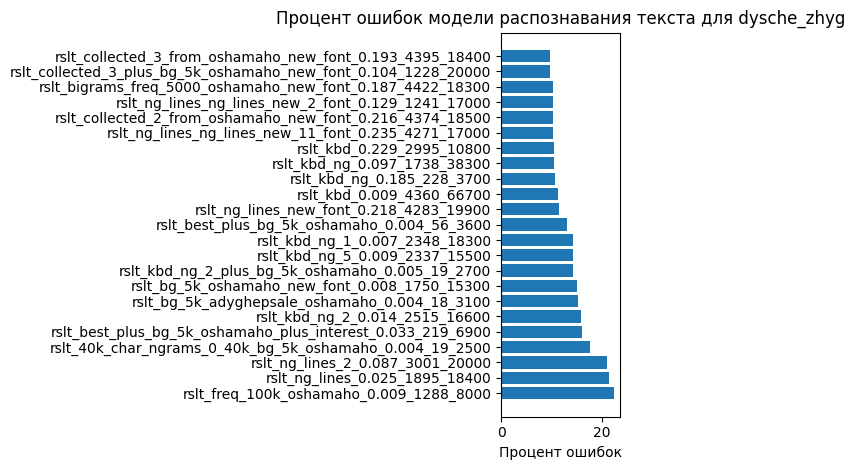

In [5]:
import matplotlib.pyplot as plt

data = sorted(percentage.items(), key=lambda x: x[1], reverse=True)
# Разделение данных на идентификаторы и значения времени выполнения
labels, times = zip(*data)

# Создание гистограммы
plt.barh(labels, times)

plt.xlabel("Процент ошибок")
plt.title(f"Процент ошибок модели распознавания текста для {pdf_name}")
plt.tight_layout()  # Автоматическая подгонка элементов на графике
plt.show()